# Simple CNN notebook

## Import Libraries

In [366]:
%matplotlib inline
import numpy as np
from utils.helper import read_data, blur, to_real, morphology
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
FOLDER = "data/data_big_2/"

## Load data

In [367]:
data_empty = read_data(FOLDER + "empty.csv")
data_1p = read_data(FOLDER + "1p.csv")
data_2p = read_data(FOLDER + "2p.csv")
data_3p = read_data(FOLDER + "3p.csv")
print("----------------Shapes----------------")
print("empty:", data_empty.shape)
print("1p:", data_1p.shape)
print("2p:", data_2p.shape)
print("3p:", data_3p.shape)


----------------Shapes----------------
empty: (720, 5, 3, 64, 64)
1p: (720, 5, 3, 64, 64)
2p: (720, 5, 3, 64, 64)
3p: (720, 5, 3, 64, 64)


In [368]:
data_1p_reshaped = data_1p.reshape(-1, 20, 3, 64, 64)
data_2p_reshaped = data_2p.reshape(-1, 20, 3, 64, 64)
data_3p_reshaped = data_3p.reshape(-1, 20, 3, 64, 64)
data_empty_reshaped = data_empty.reshape(-1, 20, 3, 64, 64)
print(f"data_1p_reshaped: {data_1p_reshaped.shape}")
print(f"data_2p_reshaped: {data_2p_reshaped.shape}")
print(f"data_3p_reshaped: {data_3p_reshaped.shape}")
print(f"data_empty_reshaped: {data_empty_reshaped.shape}")


data_1p_reshaped: (180, 20, 3, 64, 64)
data_2p_reshaped: (180, 20, 3, 64, 64)
data_3p_reshaped: (180, 20, 3, 64, 64)
data_empty_reshaped: (180, 20, 3, 64, 64)


In [375]:
data_empty_abs = np.abs(data_empty_reshaped)
data_1p_abs = np.abs(data_1p_reshaped)
data_2p_abs = np.abs(data_2p_reshaped)
data_3p_abs = np.abs(data_3p_reshaped)
print(f"data_empty_abs: {data_empty_abs.shape}")
print(f"data_1p_abs: {data_1p_abs.shape}")
print(f"data_2p_abs: {data_2p_abs.shape}")
print(f"data_3p_abs: {data_3p_abs.shape}")


data_empty_abs: (180, 20, 3, 64, 64)
data_1p_abs: (180, 20, 3, 64, 64)
data_2p_abs: (180, 20, 3, 64, 64)
data_3p_abs: (180, 20, 3, 64, 64)


In [751]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def calculate_saliency_map_3(frames, to_morph=True):
    """n_frames, n_radars, 64, 64"""
    """new_frames = []
    for frame in frames:
        mean = np.mean(frame)
        frame_new = np.where(frame > mean, frame, 0)
        new_frames.append(frame_new)
    new_frames = np.array(new_frames)
    frames = new_frames"""
    frames[:, :, 31:34, :] = 0
    # differences = np.abs(np.diff(frames, axis=0))
    # print(differences.shape)
    multiplications = np.zeros((frames.shape[0] - 1, frames.shape[1], 64, 64))
    for i in range(frames.shape[0] - 1):
        for j in range(frames.shape[1]):
            mult = np.multiply(frames[i, j, :, :], frames[i + 1, j, :, :])
            multiplications[i, j, :, :] = mult

    if to_morph:
        morphology = np.zeros(multiplications.shape)
        for i in range(multiplications.shape[0]):
            for j in range(multiplications.shape[1]):
                morph = cv2.morphologyEx(
                    multiplications[i, j, :, :], cv2.MORPH_OPEN, np.ones((2, 2))
                )
                morphology[i, j, :, :] = morph
        saliency_map = np.expand_dims(np.sum(morphology, axis=0), axis=0)
    else:
        saliency_map = np.expand_dims(np.sum(multiplications, axis=0), axis=0)

    return normalize_data(saliency_map).squeeze()


def calculate_saliency_map_1(frames, to_morph=True):
    new_frames = []
    for frame in frames:
        mean = np.median(frame)
        frame_new = np.where(frame > mean, frame, 0)
        new_frames.append(frame_new)
    new_frames = np.array(new_frames)
    frames = new_frames
    frames[:, 31:34, :] = 0
    multiplications = []
    for i in range(frames.shape[0] - 1):
        multiplications.append(np.multiply(frames[i], frames[i + 1]))

    multiplications = np.array(multiplications)
    if to_morph:
        morph = np.array(
            [
                cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((5, 5)))
                for img in multiplications
            ]
        )
        saliency_map = np.expand_dims(np.sum(morph, axis=0), axis=0)
    else:
        saliency_map = np.expand_dims(np.sum(multiplications, axis=0), axis=0)

    return normalize_data(saliency_map).squeeze()


def derivative(frames):
    frames[:, 31:34, :] = 0
    img = np.sum(frames, axis=0).squeeze()
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)

    return sobelx


def subtract_noise(data, indices, noise):
    data[indices]
    pass


def find_peaks_2d(img, r=3):
    
    img_new = np.zeros(img.shape)
    for y in range(r, img.shape[0] - r + 1):
        for x in range(r, img.shape[1] - r + 1):
            if img[y, x] > 0.15:
                neighboors = img[y - r : y + r + 1, x - r : x + r + 1]
                if np.max(neighboors) == img[y, x]:
                    img_new[y - r : y + r + 1, x - r : x + r + 1] = normalize_data(
                        neighboors
                    )
    return img_new


def find_peaks_2d_grad(img, r=11):
    img_new = np.zeros(img.shape)
    for y in range(r, img.shape[0] - r + 1, r//2):
        for x in range(r, img.shape[1] - r + 1, r//2):
            keep = True
            substractions_old_mean = 0
            for i in range(1, r // 2 + 1):
                neighboors = img[y - i : y + i + 1, x - i : x + i + 1]
                substractions = img[y, x] - neighboors
                substractions_mean = np.mean(substractions)

                if (
                    np.sum(substractions > 0) / len(substractions) > 0.99
                    and substractions_mean > substractions_old_mean
                ):
                    keep = True
                else:
                    keep = False
                    break
                substractions_old_mean = substractions_mean
            if keep:
                img_new[y - r : y + r + 1, x - r : x + r + 1] = normalize_data(
                    img[y - r : y + r + 1, x - r : x + r + 1]
                )
    return img_new


def easy_preprocessing(frames):
    new_frames = []
    for frame in frames:
        mean = np.median(frame)
        frame_new = np.where(frame > mean, frame, 0)
        new_frames.append(frame_new)
    new_frames = np.array(new_frames)
    frames = new_frames
    frames[:, :, 31:34, :] = 0
    img = np.sum(frames, axis=0).squeeze()
    img_new = np.zeros(img.shape)
    for i in range(img.shape[0]):
        peaks = find_peaks_2d_grad(normalize_data(img[i, :, :]))
        img_new[
            i, :, :
        ] = peaks  # cv2.morphologyEx(peaks, cv2.MORPH_CLOSE, np.ones((6, 6)))

    return img_new


In [752]:
data_empty_diffs = np.array([easy_preprocessing(sample) for sample in data_empty_abs])
print("ready")
data_1p_diffs = np.array([easy_preprocessing(sample) for sample in data_1p_abs])
print("ready")
data_2p_diffs = np.array([easy_preprocessing(sample) for sample in data_2p_abs])
print("ready")
data_3p_diffs = np.array([easy_preprocessing(sample) for sample in data_3p_abs])
print("ready")

print(f"data_empty_diffs: {data_empty_diffs.shape}")
print(f"data_1p_diffs: {data_1p_diffs.shape}")
print(f"data_2p_diffs: {data_2p_diffs.shape}")
print(f"data_3p_diffs: {data_3p_diffs.shape}")


ready
ready
ready
ready
data_empty_diffs: (180, 3, 64, 64)
data_1p_diffs: (180, 3, 64, 64)
data_2p_diffs: (180, 3, 64, 64)
data_3p_diffs: (180, 3, 64, 64)


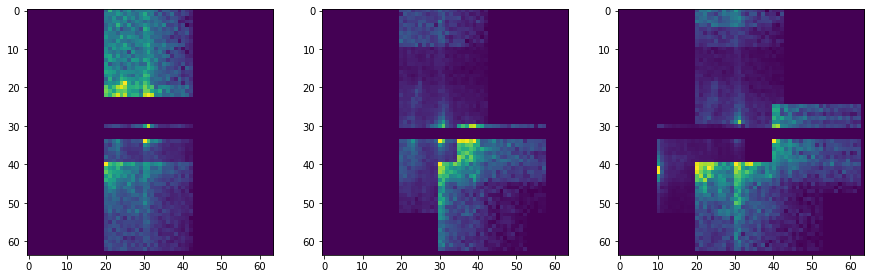

In [772]:
##### plot random sample
random_sample = np.random.randint(0, data_empty_diffs.shape[0])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_sample = data_1p_diffs.copy()
ax[0].imshow(plot_sample[random_sample, 0, :, :])
ax[1].imshow(plot_sample[random_sample, 1, :, :])
ax[2].imshow(plot_sample[random_sample, 2, :, :])


In [555]:
data_0 = np.moveaxis(data_empty_diffs, 1, 3)
data_1 = np.moveaxis(data_1p_diffs, 1, 3)
data_2 = np.moveaxis(data_2p_diffs, 1, 3)
data_3 = np.moveaxis(data_3p_diffs, 1, 3)
print(data_0.shape)
print(data_1.shape)
print(data_2.shape)
print(data_3.shape)
# data_0 = data_empty_diffs
# data_1 = data_1p_diffs
# data_2 = data_2p_diffs
# data_3 = data_3p_diffs
# print(data_0.shape)
# print(data_1.shape)
# print(data_2.shape)
# print(data_3.shape)


(180, 64, 64, 3)
(180, 64, 64, 3)
(180, 64, 64, 3)
(180, 64, 64, 3)


In [556]:
data_tot = np.concatenate((data_0, data_1, data_2, data_3), axis=0)
data_tot.shape


(720, 64, 64, 3)

### Create Labels

In [557]:
labels_empty = np.zeros(data_0.shape[0])
labels_1p = np.ones(data_1.shape[0])
labels_2p = np.ones(data_2.shape[0]) * 2
labels_3p = np.ones(data_3.shape[0]) * 3
labels = np.concatenate((labels_empty, labels_1p, labels_2p, labels_3p), axis=0)
print("Labels shape:", labels.shape)


Labels shape: (720,)


In [558]:
train_labels_one_hot = np.eye(4)[labels.astype(int)]
print("Labels abels one hot shape:", train_labels_one_hot.shape)


Labels abels one hot shape: (720, 4)


In [559]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    data_tot, train_labels_one_hot, test_size=0.1, stratify=labels
)
print(f"Shape train_X: {train_X.shape}")
print(f"Shape test_X: {test_X.shape}")
print(f"Shape train_y: {train_y.shape}")
print(f"Shape test_y: {test_y.shape}")


Shape train_X: (648, 64, 64, 3)
Shape test_X: (72, 64, 64, 3)
Shape train_y: (648, 4)
Shape test_y: (72, 4)


In [560]:
models = keras.models
layers = keras.layers

model = models.Sequential(
    [
        layers.Conv2D(
            4, input_shape=(64, 64, 3), kernel_size=5, padding="same", activation="relu"
        ),
        layers.MaxPooling2D(2, strides=None, padding="valid"),
        layers.Conv2D(
            4,
            #   input_shape = (32,32, 1),
            kernel_size=3,
            padding="same",
            activation="relu",
        ),
        layers.MaxPooling2D(2, strides=None, padding="valid"),
        layers.Conv2D(
            4,
            #   input_shape = (32,32, 1),
            kernel_size=3,
            padding="same",
            activation="relu",
        ),
        layers.MaxPooling2D(2, strides=None, padding="valid"),
        layers.Conv2D(
            2,
            #   input_shape = (32,32, 1),
            kernel_size=3,
            padding="same",
            activation="relu",
        ),
        layers.MaxPooling2D(2, strides=None, padding="valid"),
        layers.Flatten(),
        layers.Dense(4),
        layers.Activation("softmax"),
    ]
)
print(model.summary())


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_119 (Conv2D)         (None, 64, 64, 4)         304       
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 32, 32, 4)        0         
 ng2D)                                                           
                                                                 
 conv2d_120 (Conv2D)         (None, 32, 32, 4)         148       
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 16, 16, 4)        0         
 ng2D)                                                           
                                                                 
 conv2d_121 (Conv2D)         (None, 16, 16, 4)         148       
                                                                 
 max_pooling2d_121 (MaxPooli  (None, 8, 8, 4)        

In [561]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

model.fit(
    train_X,
    train_y,
    epochs=1000,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=keras.callbacks.EarlyStopping(patience=10),
)

model.save("models/CNN_Sobol")


Epoch 1/1000
19/19 [==============================] - 1s 45ms/step - loss: 1.2820 - accuracy: 0.2796 - val_loss: 1.1202 - val_accuracy: 0.4000
Epoch 2/1000
19/19 [==============================] - 1s 36ms/step - loss: 1.1559 - accuracy: 0.3859 - val_loss: 1.0533 - val_accuracy: 0.5385
Epoch 3/1000
19/19 [==============================] - 1s 37ms/step - loss: 1.0923 - accuracy: 0.5026 - val_loss: 0.9987 - val_accuracy: 0.5692
Epoch 4/1000
19/19 [==============================] - 1s 36ms/step - loss: 1.0449 - accuracy: 0.5043 - val_loss: 0.9650 - val_accuracy: 0.5846
Epoch 5/1000
19/19 [==============================] - 1s 35ms/step - loss: 1.0027 - accuracy: 0.5111 - val_loss: 0.9316 - val_accuracy: 0.5692
Epoch 6/1000
19/19 [==============================] - 1s 39ms/step - loss: 0.9532 - accuracy: 0.5334 - val_loss: 0.8926 - val_accuracy: 0.5846
Epoch 7/1000
19/19 [==============================] - 1s 37ms/step - loss: 0.8875 - accuracy: 0.5695 - val_loss: 0.8443 - val_accuracy: 0.5846

INFO:tensorflow:Assets written to: models/CNN_Sobol\assets


INFO:tensorflow:Assets written to: models/CNN_Sobol\assets


In [562]:
loss, aacuracy = model.evaluate(test_X, test_y)
print(f"Loss: {loss}")
print(f"Accuracy: {aacuracy}")


3/3 [==============================] - 0s 9ms/step - loss: 0.8403 - accuracy: 0.6806
Loss: 0.8403193950653076
Accuracy: 0.6805555820465088


In [563]:
from sklearn.metrics import confusion_matrix

predicted = model.predict(test_X)
predicted_label = np.argmax(predicted, axis=1)
true_label = np.argmax(test_y, axis=1)
confusion_matrix(true_label, predicted_label)


3/3 [==============================] - 0s 8ms/step


array([[18,  0,  0,  0],
       [ 1, 12,  3,  2],
       [ 0,  7,  6,  5],
       [ 0,  0,  5, 13]], dtype=int64)